In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read train data and test data
f_train = open("../data/train.json", 'r')
train_data = json.load(f_train)

f_test = open("../data/test.json", 'r')
test_data = json.load(f_test)


def handle_authors(data):
    n_samples = len(data)
    empty_idx = []

    for i in tqdm(range(n_samples), desc="delet some useless data"):
        authors = data[i]['authors']
        p_author = 0

        for au in authors:
            if au < 100:
                p_author += 1
        
        if p_author == 0:
            empty_idx.append(i)
    
    discard_idx = empty_idx[:len(empty_idx)-(n_samples-len(empty_idx))]

    return discard_idx


def get_attr_matrix(data, discard_idx=[], train=True):
    n_samples = len(data)
    n_features = 5000 -1 

    # get abstract & title feature
    # 序列信息 ！！！！
    # 语言模型
    # lstm （*）

    #   XX bert pre-trained / 去掉embedding层 **


    if train:
        wmatrix = torch.zeros([n_samples-len(discard_idx), n_features])
    else:
        wmatrix = torch.zeros([n_samples, n_features])

    INDEX = 0
    for i in tqdm(range(n_samples), desc="title & abstract"):

        if i in discard_idx and train:
            continue

        instance = data[INDEX]
        for title in instance['title']:
            wmatrix[INDEX, title-1] += 1
        for abstract in instance['abstract']:
            wmatrix[INDEX, abstract-1] += 1
        INDEX += 1

    # get venue feature
    # embedding

    if train:
        vmatrix = torch.zeros([n_samples-len(discard_idx), 1])
    else:
        vmatrix = torch.zeros([n_samples, 1])

    INDEX = 0
    for i in tqdm(range(n_samples), desc="venue"):
        if i in discard_idx and train:
            continue

        venue = data[INDEX]['venue']
        
        if venue:
            vmatrix[INDEX, ] = venue
        else:
            vmatrix[INDEX, ] = -1
        INDEX += 1

    # get year feature !!!!!
    # 1-d 编码器 年份 输出特征 -》 256维
    # distribution of 
    # nn.Embedding() // input: batch-size * 1 // output: batch-size * embedding-size

    if train:
        ymatrix = torch.zeros([n_samples-len(discard_idx), 1])
    else:
        ymatrix = torch.zeros([n_samples, 1])
    

    INDEX = 0
    for i in tqdm(range(n_samples), desc="year"):
        if i in discard_idx and train:
            continue

        year = data[INDEX]['year']
        
        if year:
            ymatrix[INDEX, ] = year
        else:
            ymatrix[INDEX, ] = -1
        INDEX += 1

    # get prolific authors 
    # co author -> feature / 单独编码
    # 多任务 - predict all authors 


    if train:
        y = torch.zeros([n_samples-len(discard_idx), 100])
        key = 'authors'
    else:
        y = None

    # get co-author matrix
    if train:
        amatrix = torch.zeros([n_samples-len(discard_idx), 21245 - 100 + 1])
    else:
        amatrix = torch.zeros([n_samples, 21245 - 100 + 1])
        key = 'coauthors'

    INDEX = 0
    for i in tqdm(range(n_samples), desc="authors"):
        if i in discard_idx and train:
            continue

        authors = data[INDEX][key]
        p_author = 0
        
        for au in authors:
            if au < 100:
                y[INDEX, au] += 1

            else:
                amatrix[INDEX, au - 100] += 1

        INDEX += 1
            
    return torch.cat((wmatrix, vmatrix, ymatrix, amatrix), 1), y

di = handle_authors(train_data)

print("Train Data")
X, y = get_attr_matrix(train_data, discard_idx=di)

print("Test Data")
X_kaggle, _ = get_attr_matrix(test_data, train=False)

print("Train:")
print("     X : ", X.shape)
print("     y : ", y.shape)
print("Test_Kaggle:")
print("     X : ", X_kaggle.shape)

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 465486.35it/s]


Train Data


authors: 100%|██████████| 25793/25793 [00:02<00:00, 9391.54it/s] 


Test Data


authors: 100%|██████████| 800/800 [00:00<00:00, 25132.71it/s]


Train:
     X :  torch.Size([14920, 26147])
     y :  torch.Size([14920, 100])
Test_Kaggle:
     X :  torch.Size([800, 26147])


In [43]:
X

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)

Train:
     X_train :  torch.Size([9996, 26147])
     y_train :  torch.Size([9996, 100])
Test_Kaggle:
     X_test  :  torch.Size([4924, 26147])
     y_test  :  torch.Size([4924, 100])


In [4]:
# `BinaryDataset()` class for multi-head binary classification model
class BinaryDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        features = self.x[index, :]
        labels = self.y[index, :]
        
        # we have 12 feature columns 
        features = torch.tensor(features, dtype=torch.float32)
        # there are 5 classes and each class can have a binary value ...
        # ... either 0 or 1
        label_dict = {'features': features}
        for i in range(100):
            key = 'label' + str(i)
            label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)

        return label_dict
        

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
## 多个class /  - 特征融合 - 过全联接层 - 输出层
## 多输出 融合

In [45]:
class MultiHeadBinaryModel(nn.Module):
    def __init__(self):
        super(MultiHeadBinaryModel, self).__init__()

        ## 1024, 512, 256, 100
        ## nn.Dropout() // 0.1, 0.2 //

        self.fc1 = nn.Linear(26147, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 100)
    
    def forward(self, x):

        # F.leaky_relu()

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outs = F.sigmoid(self.out(x)) 

        return outs


In [153]:
import torch.nn as nn
# custom loss function for multi-head binary classification
# binary_loss_fn
def loss_fn(outputs, targets):

    n_class = 100
    sum_ = 0
    
    for i in range(n_class):
        
        # outputs_ = torch.reshape(outputs[i], (-1,))
        outputs_ = outputs[:, i]

        '''for j in range(len(outputs_)):

            ## threshold !!!!!!!!
            ## threshold 
            ## 每个人阈值不同，>0.5, 降低threshold, 
            ## 0.2 ? (0.1) => recall
            
            if outputs_[j] > 0.2:
                outputs_[j] = 1
            else:
                outputs_[j] = 0'''
        
        sum_ += nn.BCELoss()(outputs_, targets[i])
        ## 多标签分类 (mse) 

    return sum_ / n_class
    

In [154]:
# from dataset import make_dataset, BinaryDataset
from torch.utils.data import DataLoader

import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [155]:
# prepare the dataset
# x_train, y_train, _, _ = make_dataset()
# print some info
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")
# train dataset
train_dataset = BinaryDataset(X_train, y_train)
# train data loader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1024)
# initialize the model
model = MultiHeadBinaryModel()

[INFO]: Number of training samples: 9996
[INFO]: Number of training features: 26147


In [159]:
# training function
def train(model, dataloader, optimizer, loss_fn, train_dataset, device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
    
        counter += 1
        
        # extract the features and labels
        features = data['features'].to(device)
        
        targets = []
        for j in range(100):
            targets.append(data[f'label{j}'].to(device))
        
        # zero-out the optimizer gradients
        optimizer.zero_grad()
        
        outputs = model(features)
        
        loss = loss_fn(outputs, targets)
        train_running_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [160]:
# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001) # 学习率衰减 / 学习率震荡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10
# load the model on to the computation device
model.to(device)

MultiHeadBinaryModel(
  (fc1): Linear(in_features=26147, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [161]:
# start the training
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'outputs/multi_head_binary.pth')

Epoch 1 of 10


  0%|          | 0/9 [00:00<?, ?it/s]/var/folders/v7/wxn3bxmn2018mjps58z5d3hw0000gn/T/ipykernel_17049/3191504715.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/var/folders/v7/wxn3bxmn2018mjps58z5d3hw0000gn/T/ipykernel_17049/3191504715.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
10it [00:32,  3.23s/it]                      


Train Loss: 0.0510
Epoch 2 of 10


10it [00:25,  2.59s/it]                      


Train Loss: 0.0341
Epoch 3 of 10


10it [00:29,  2.96s/it]                      


Train Loss: 0.0285
Epoch 4 of 10


10it [00:30,  3.04s/it]                      


Train Loss: 0.0262
Epoch 5 of 10


10it [00:28,  2.84s/it]                      


Train Loss: 0.0239
Epoch 6 of 10


10it [00:26,  2.64s/it]                      


Train Loss: 0.0223
Epoch 7 of 10


10it [00:25,  2.56s/it]                      


Train Loss: 0.0210
Epoch 8 of 10


10it [00:25,  2.51s/it]                      


Train Loss: 0.0198
Epoch 9 of 10


10it [00:29,  3.00s/it]                      


Train Loss: 0.0186
Epoch 10 of 10


10it [00:26,  2.69s/it]                      


Train Loss: 0.0173
=== Running duration ===
281.59160900115967 s


In [167]:
# torch.save(model.state_dict(), 'outputs/multi_head_binary_epoch.pth')

In [168]:
# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")
# train dataset
test_dataset = BinaryDataset(X_test, y_test)
# train data loader
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

[INFO]: Number of testing samples: 4924
[INFO]: Number of testing features: 26147


In [169]:
model = MultiHeadBinaryModel()
model = MultiHeadBinaryModel()
model.load_state_dict(torch.load('outputs/multi_head_binary_epoch.pth'))
model.to(device)
model.eval()

MultiHeadBinaryModel(
  (fc1): Linear(in_features=26147, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [170]:
target_label_list = []
for i in range(y_test.shape[0]):
    tmp = ""
    for j in range(100):
        if y_test[i][j] > 0.5:
            tmp += str(j) + " "
    if tmp:
        target_label_list.append(tmp[: -1])
    else:
        target_label_list.append("-1")

In [207]:
start = time.time()
predict_list = []

for i, test_sample in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    # print(f"SAMPLE {i}")
    # extract the features and labels
    features = test_sample['features'].to(device)
    
    outputs = model(features)

    outputs = outputs.squeeze()
            
    # get all the labels
    all_labels = []
    for out in outputs:
        # Threshold set to 0.2
        if out >= 0.8:
            all_labels.append(1)
        else:
            all_labels.append(0)
    
    tmp_ = ""
    for j in range(100):
        if all_labels[j] == 1:
            tmp_ += str(j) + " "
    if tmp_:
        predict_list.append(tmp_[:-1])
    else:
        predict_list.append("-1")
        
    
print("=== Running duration ===")
print(time.time() - start, 's')

  0%|          | 0/4924 [00:00<?, ?it/s]/var/folders/v7/wxn3bxmn2018mjps58z5d3hw0000gn/T/ipykernel_17049/3191504715.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/var/folders/v7/wxn3bxmn2018mjps58z5d3hw0000gn/T/ipykernel_17049/3191504715.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████

=== Running duration ===
36.15157175064087 s


In [208]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

print('='*25 + 'Evaluation results' + '='*25)
print('The accuracy score of prediction is : {}'.format(accuracy_score(target_label_list, predict_list)))
print('The recall   score of prediction is : {}'.format(recall_score(target_label_list, predict_list, average='weighted')))
print('The f1       score of prediction is : {}'.format(f1_score(target_label_list, predict_list, average='weighted')))

=========================Evaluation results=========================
The accuracy score of prediction is : 0.7175060926076361
The recall   score of prediction is : 0.7175060926076361
The f1       score of prediction is : 0.5994913149303012


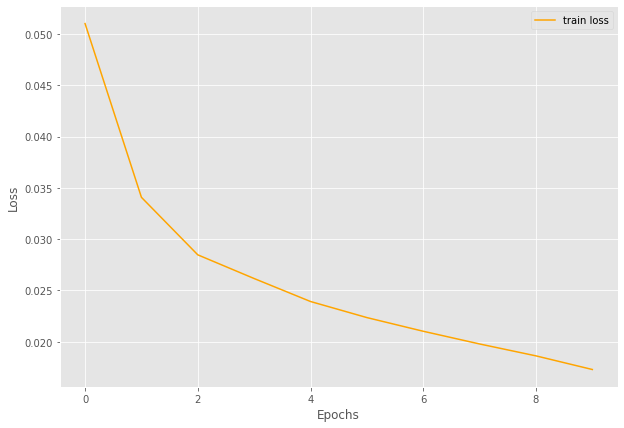

In [209]:
# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()

# Kaggle Predictions

In [210]:
# print some info
print(f"[INFO]: Number of testing samples: {X_kaggle.shape[0]}")
print(f"[INFO]: Number of testing features: {X_kaggle.shape[1]}")
# train dataset
kaggle_dataset = BinaryDataset(X_kaggle, _)
# train data loader
kaggle_dataloader = DataLoader(kaggle_dataset, shuffle=False, batch_size=1)

[INFO]: Number of testing samples: 800
[INFO]: Number of testing features: 26147


In [231]:
predict_list_kaggle = []

# for i, test_sample in tqdm(enumerate(kaggle_dataloader), total=len(kaggle_dataloader)):
for test_sample in tqdm(X_kaggle):
    # print(f"SAMPLE {i}")
    # extract the features and labels
    features = test_sample
    
    outputs = model(features)

    outputs = outputs.squeeze()
            
    # get all the labels
    all_labels = []
    for out in outputs:
        # Threshold set to 0.2
        if out >= 0.67:
            all_labels.append(1)
        else:
            all_labels.append(0)
    
    tmp_ = ""
    for j in range(100):
        if all_labels[j] == 1:
            tmp_ += str(j) + " "
    if tmp_:
        predict_list_kaggle.append(tmp_[:-1])
    else:
        predict_list_kaggle.append("-1")

  0%|          | 0/800 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 800/800 [00:05<00:00, 151.07it/s]


In [232]:
import pandas as pd

def kaggle_output(predicts):
    
    output_df = pd.DataFrame(columns=["ID", "Predict"])
    output_df['Predict'] = predicts
    output_df['ID'] = output_df.index
    output_df = output_df.set_index('ID')

    return output_df

In [233]:
kaggle = kaggle_output(predict_list_kaggle)
kaggle.to_csv("../kaggle/predict5.csv")

In [234]:
for i in kaggle['Predict']:
    if i != '-1':
        print(i)

70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70


In [230]:
max_ = 0

for instance in test_data:
    year = instance['year']
    if year > max_:
        max_ = year
print(max_)

19
